In [49]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer



pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


In [50]:
df = pd.read_csv('hr_raw_data_v2.csv')

In [51]:
df.head()

,employee_number,gender,birth_year,age,marital_status,dist_home,job_title,department,terminated,year_at_comp,year_current_role,standard_hours,remote,business_travel,over_time,job_level,stock_opt_level,traning_times_last_year,perf_rate,year_last_promotion,year_current_mngr,education_field,education_scale,annual_salary,monthly_income,daily_rate,hourly_rate,monthly_rate,perc_salary_hike,env_sat_rate,job_involvement,job_sat_rate,relationship_sat_rate,work_life_balance,num_comp_worked,tot_working_year
0,1,M,1972,51,Unknown,6,Research Director,Research & Development,No,20,NaN,Full Time,Yes,Unknown,No,5,0,5,"3,0",15,15,Unknown,3,195370.00,16280.830000,2015.722222,NaN,"42330,17$",13,1,3,3,3,"3,0",7,NaN
1,2,M,1971,52,Unknown,1,Manager,Unknown,No,33,NaN,NaN,Yes,Unknown,Unknown,5,1,5,"3,0",11,9,Life Sciences,4,199990.00,16125.406667,2063.388889,NaN,"43331,17$",14,3,2,3,1,"3,0",0,"34,0"
2,3,M,1981,42,Married,4,Manager,Research & Development,No,22,NaN,NaN,Yes,travel_rarely,No,5,0,3,"3,0",11,15,Technical Degree,2,192320.00,15943.720000,1984.253968,NaN,"41669,33$",11,3,3,4,4,NaN,1,"22,0"
3,4,F,1976,47,Married,2,Research Director,Research & Development,No,20,NaN,Full Time,No,travel_rarely,Unknown,4,2,2,"3,0",5,6,Medical,4,171690.00,14307.500000,1771.404762,NaN,"37199,50$",19,1,3,3,2,NaN,3,NaN
4,5,F,1977,46,Divorced,3,Sales Executive,Sales,No,19,NaN,NaN,No,Unknown,No,4,1,5,"3,0",2,8,Technical Degree,3,153407.07,12783.920000,1582.771346,NaN,"33238,20$",12,1,4,1,4,"3,0",2,NaN


Text(0.5, 1.0, 'Correlation salary & gender')

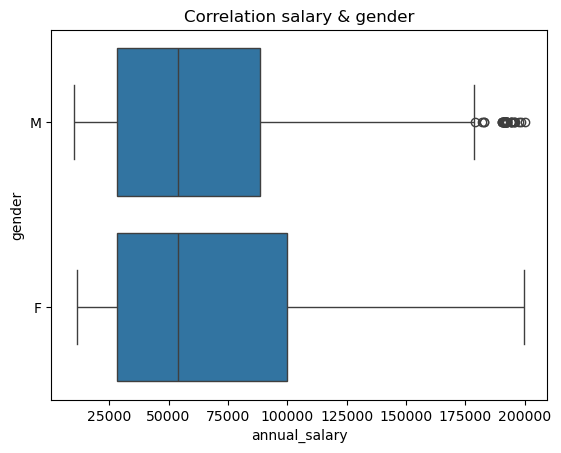

In [52]:
sns.boxplot(data=df, y='gender', x='annual_salary')
plt.title('Correlation salary & gender')

In [53]:
df['standard_hours'].mode()

0    Part Time
Name: standard_hours, dtype: object

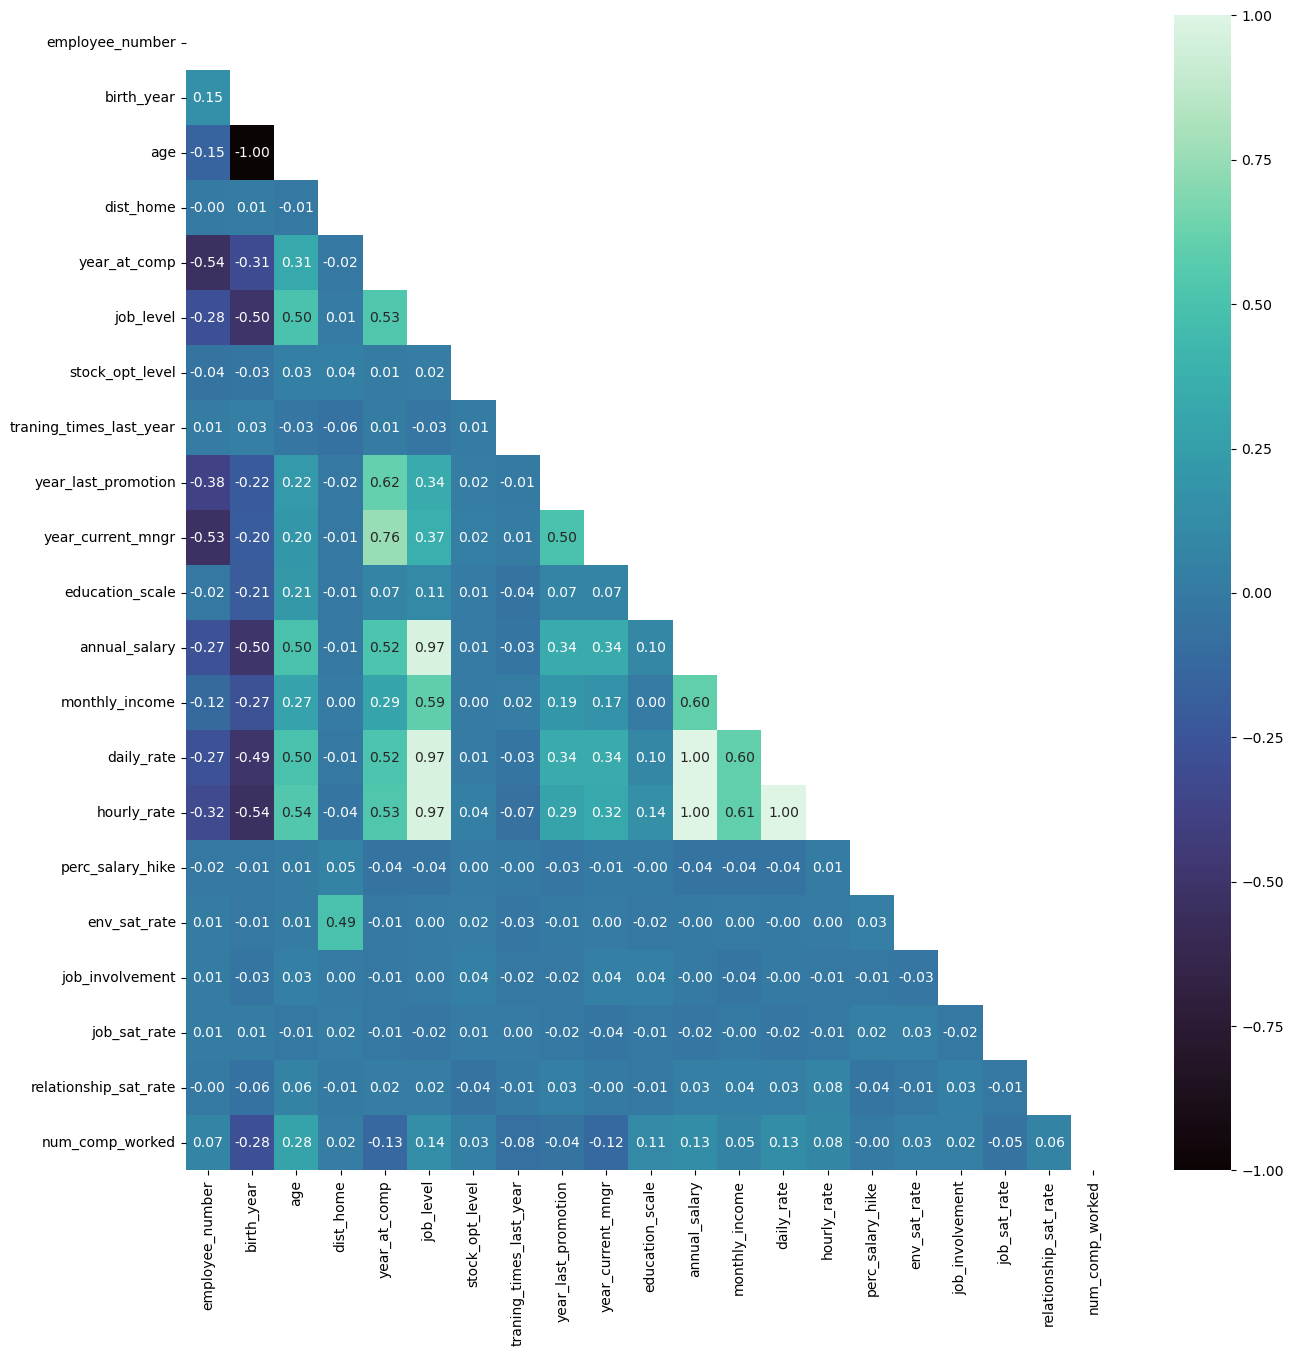

In [54]:
# GENERAL DATA ANALYSIS

numerics = df.select_dtypes(exclude = 'O').columns
df_corr = df[numerics].corr(method = 'pearson')


plt.figure(figsize = (15, 15))

mask = np.triu(np.ones_like(df_corr, dtype=bool))

sns.heatmap(df_corr, 
            annot = True, 
            fmt = ".2f", 
            cmap = "mako", 
            vmax = 1, 
            vmin = -1, 
            mask = mask); 

In [55]:
display(df.dtypes)

employee_number              int64
gender                      object
birth_year                   int64
age                          int64
marital_status              object
dist_home                    int64
job_title                   object
department                  object
terminated                  object
year_at_comp                 int64
year_current_role           object
standard_hours              object
remote                      object
business_travel             object
over_time                   object
job_level                    int64
stock_opt_level              int64
traning_times_last_year      int64
perf_rate                   object
year_last_promotion          int64
year_current_mngr            int64
education_field             object
education_scale              int64
annual_salary              float64
monthly_income             float64
daily_rate                 float64
hourly_rate                float64
monthly_rate                object
perc_salary_hike    